# EPFL Machine Learning Higgs

## Loading and preprocessing

In [ ]:
import math
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
from helpers import load_data, one_hot_encode, standardize

In [ ]:
data_directory = '../data'
train_dataset_path = os.path.join(data_directory, 'train.csv')
public_test_dataset_path = os.path.join(data_directory, 'test.csv')

# Loading the data
_, Y_train_public, feature_names, X_train_public = load_data(train_dataset_path)
ids_test_public, _, _, X_test_public = load_data(public_test_dataset_path)

In [ ]:
# We need to deal with -999 somehow (missing values)
# First of all, we make sure they do not contribute to computing the mean and std
# Since they are floats, we add an epsilon against numerical errors
EPSILON = 1E-4
mask_train = np.abs(X_train_public + 999) <= EPSILON
mask_test = np.abs(X_test_public + 999) <= EPSILON

print('Proportion of missing values:', np.sum(mask_train)/(mask_train.shape[0]*mask_train.shape[1]))
print('Proportion of missing values:', np.sum(mask_test)/(mask_test.shape[0]*mask_test.shape[1]))

In [81]:
# We will standardize the data based on the mean and standard deviation of the public train dataset
# It ignores NaN values for computing the mean and std for the standardization
# ! The method standardizes in-place !
continuous_column_idxs = np.where(feature_names != "PRI_jet_num")[0]
column_means, column_stds = standardize(X_train_public, continuous_column_idxs)
_, _ = standardize(X_test_public, continuous_column_idxs, column_means, column_stds)

# Finally, we set the NaNs to the mean of the standardized dataset, namely, 0
X_train_public = np.nan_to_num(X_train_public, nan=0.0)
X_test_public = np.nan_to_num(X_test_public, nan=0.0)

In [82]:
# We will need to add interaction terms to deal with co-linearity somewhere (like x1*x2 instead of just x1 and x2)


                  0              1              2              3   \
count  568238.000000  568238.000000  568238.000000  568238.000000   
mean        0.000723       0.000525      -0.001461      -0.001050   
std         0.999197       1.001376       0.991316       0.994484   
min        -2.337859      -1.393127      -1.821565      -0.909519   
25%         0.313069      -0.846229      -0.532886      -0.686408   
50%         0.379242      -0.078451      -0.182274      -0.305142   
75%         0.442478       0.690064       0.268948       0.335557   
max         4.917705      26.013128      28.993959      20.097084   

                  4              5              6              7   \
count  568238.000000  568238.000000  568238.000000  568238.000000   
mean        0.002154       0.002289       0.002146       0.001419   
std         1.000995       1.001647       1.000983       0.996256   
min        -0.639367      -0.604530      -0.639363      -2.728412   
25%        -0.639367      -0.6045

In [ ]:
# Then we will need to notice the discrete-valued column, since this needs to be one-hot encoded
# In our dataset, only "PRI_jet_num" is discrete.
discrete_column_idxs = np.where(feature_names == "PRI_jet_num")[0]

# Update the features by one-hot encoding the discrete ones, but only update the feature names at the end
# They will be the same for the train and test set anyway
X_train_public, _ = one_hot_encode(X_train_public, discrete_column_idxs, feature_names)
X_test_public, feature_names = one_hot_encode(X_test_public, discrete_column_idxs, feature_names)

In [ ]:
# Since this is a binary classification problem, we do not need to one-hot encode the y-vector, but we can just use binary values
positive_sample = 'b'
negative_sample = 's'
Y_train_public = np.expand_dims((Y_train_public == positive_sample).astype(np.int32), axis=1)

# ! There are quite some more positive than negative samples, maybe we could try to weigh negative samples more or something? !
print('Number of positive samples:', np.sum(Y_train_public))
print('Number of negative samples:', len(Y_train_public) - np.sum(Y_train_public))

# Training and analysis

After preprocessing, the new features of the public train- and test dataset are stored in "X_train_public" and "X_test_public". The labels are binary values stored in "Y_train_public". Furthermore, the feature column names are found in "feature_names"

In [ ]:
# We will do k-fold cross validation to create subsets of the training and testing datasets
print(feature_names)
print(X_train_public.shape, X_test_public.shape)
print(Y_train_public.shape)

In [112]:
from helpers import train_test_split
# Now we can do some training
from implementations import reg_logistic_regression

X_train, X_test, Y_train, Y_test = train_test_split(X_train_public, Y_train_public, train_proportion=0.01)

w, loss = reg_logistic_regression(Y_train, X_train, lambda_=0, initial_w=np.zeros(shape=(X_train.shape[1], 1)), max_iters=100000, gamma=0.1)
print('GD loss:', loss)
print('Weights:', w)

100%|██████████| 100000/100000 [01:00<00:00, 1651.91it/s]

GD loss: 0.5537750443090561
Weights: [[-5.16076014e-02]
 [ 5.90909857e-01]
 [ 8.15099497e-01]
 [-1.50802044e-01]
 [ 6.12436203e-01]
 [-1.77977853e+00]
 [-1.43658799e-03]
 [-8.35855928e-01]
 [ 6.44870593e-02]
 [-3.12994545e-02]
 [ 5.98506334e-01]
 [-3.04667143e-01]
 [ 3.96560798e-01]
 [-5.51524202e-01]
 [-5.09366362e-02]
 [-1.55253475e-03]
 [-8.40804040e-01]
 [ 4.98235415e-02]
 [ 5.62422443e-02]
 [-2.72215726e-01]
 [-4.64081206e-03]
 [ 2.35904735e-01]
 [-3.16373031e-01]
 [ 3.47889105e-01]
 [ 2.06659505e-01]
 [-8.43490973e-01]
 [ 3.25065280e-01]
 [ 2.24485410e-01]
 [ 2.79161761e-01]
 [-3.96968351e-02]
 [-3.28597143e-01]
 [ 2.19535535e-01]
 [ 2.93334882e-01]]


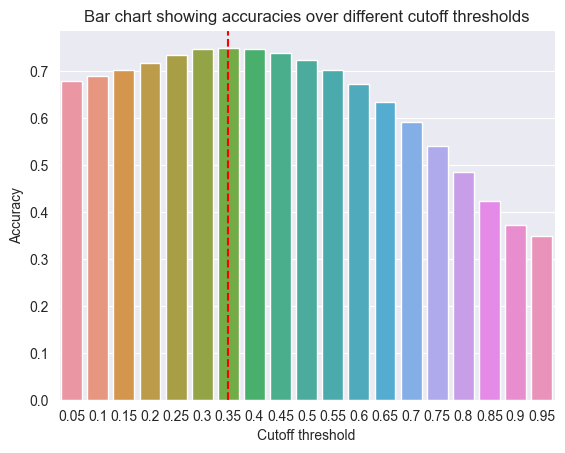

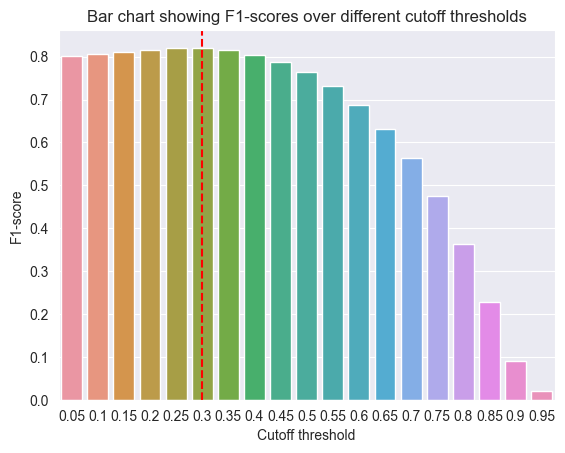

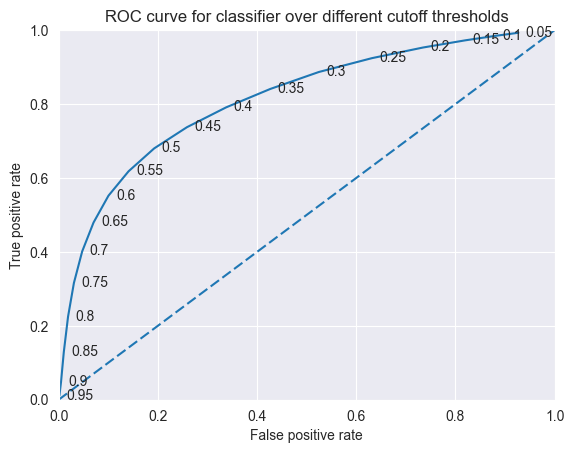

In [113]:
# Now we can evaluate the training
# ! We can actually also do some hyperparameter tuning (using ROC curves to determine the right cut-off probability) !

# Note ROC curves do not work well for linear regression, since there could be values that are not between 0 and 1!
# In this temporary example I just clip the predictions between 0 and 1

from metrics import confusion_matrix_statistics, LogisticRegressionLoss
import matplotlib.pyplot as plt
import seaborn as sns

num_values = 20
cutoff_values = [(i+1)/num_values for i in range(num_values-1)]

accuracies = []
f1_scores = []
tprs = []
fprs = []

for cutoff_value in cutoff_values:
    predictions = (LogisticRegressionLoss.sigmoid(X_test @ w) > cutoff_value).astype(np.int32)
    tp, fp, fn, tn, accuracy, tpr, _, f1_score, fpr = confusion_matrix_statistics(predictions, Y_test)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    tprs.append(tpr)
    fprs.append(fpr)

plt.figure()
ax = sns.barplot(x=cutoff_values, y=accuracies)
largest_idx = np.argmax(accuracies)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax.set(title='Bar chart showing accuracies over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='Accuracy')
plt.show()

plt.figure()
largest_idx = np.argmax(f1_scores)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax = sns.barplot(x=cutoff_values, y=f1_scores)
ax.set(title='Bar chart showing F1-scores over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='F1-score')
plt.show()

plt.figure()
ax = sns.lineplot(x=fprs, y=tprs, legend=False)
ax.set(title='ROC curve for classifier over different cutoff thresholds', xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.axline((0, 0), slope=1, dashes=(5, 2))
for i in range(len(tprs)):
    if i % math.ceil(0.05*len(cutoff_values)) == 0:
        plt.text(x=fprs[i]+0.015,y=tprs[i]-0.01, s=str(round(cutoff_values[i], 2)))
plt.show()

# Inference

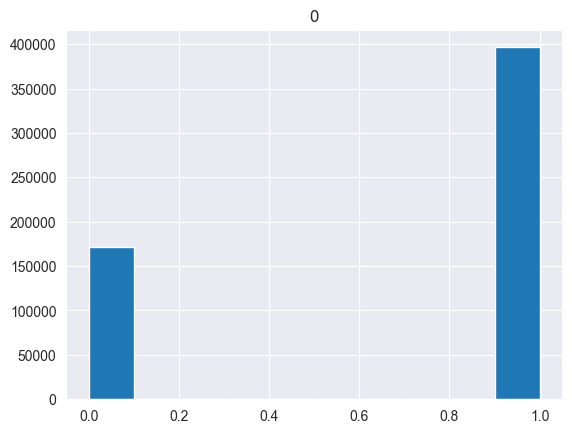

In [114]:
# Placeholder, array with True of False whether it belongs to the positive or negative sample
best_cutoff = 0.35

predictions = (LogisticRegressionLoss.sigmoid(X_test_public @ w) > best_cutoff).astype(np.int32)

submission_file_name = 'submission_0.csv'
with open(os.path.join(data_directory, submission_file_name), mode='w', newline='', encoding='utf-8') as submission_file:
    writer = csv.writer(submission_file, delimiter=',')
    writer.writerow(['Id', 'Prediction'])
    for i, prediction in enumerate(predictions):
        writer.writerow([ids_test_public[i], 1 if prediction else -1])
